### Importing Data and Packages

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from sklearn.model_selection import  GridSearchCV
from sklearn.cluster import MeanShift, KMeans, estimate_bandwidth, DBSCAN, MiniBatchKMeans, Birch
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None

First it is necessary to set the column types, so the date column will be set as ordinal and id column to category. Year and month column are not necessary since the date column contains both informations 

In [2]:
df = pd.read_excel("./data/base_analise_exploratoria.xlsx", sheet_name="teste_clusterizacao")

df['rec_previous_month_ticket_medio'] = df['rec_previous_month_mf']/df['rec_previous_month_qtd_mov']

df['rec_previous_month_ticket_medio_delta'] = df['rec_month_ticket_medio']  - df['rec_previous_month_ticket_medio']

df.drop(columns=['rec_month_part', 'rec_year_part'], inplace=True)

df['rec_est_id'] = df['rec_est_id'].astype("category")
ordinal_variables = ['rec_month']
numeric_variables = list(set(df.columns) - set(ordinal_variables) - set(['rec_est_id', 'rec_monthly_category']))

le = LabelEncoder()
for column in ordinal_variables:
    df[column] = le.fit_transform(df[column])


display(HTML(df.head(n=10).to_html()))

Once preprocessed the data has to be splited into 6 dataframes, one for each category

In [3]:
df_churn = df.loc[df['rec_monthly_category'] == 'Churn'].drop(columns=['rec_monthly_category'])
print(f"Churn length: {len(df_churn)}")

df_no_mov = df.loc[df['rec_monthly_category'] == 'Nunca Mov'].drop(columns=['rec_monthly_category'])
print(f"Nunca Mov length: {len(df_no_mov)}")

df_recorr = df.loc[df['rec_monthly_category'] == 'Recorrente'].drop(columns=['rec_monthly_category'])
print(f"Recorrente length: {len(df_recorr)}")

df_recup = df.loc[df['rec_monthly_category'] == 'Recuperação'].drop(columns=['rec_monthly_category'])
print(f"Recuperação length: {len(df_recup)}")

df_novo = df.loc[df['rec_monthly_category'] == 'Novo'].drop(columns=['rec_monthly_category'])
print(f"Novo length: {len(df_novo)}")

df_perda = df.loc[df['rec_monthly_category'] == 'Perda'].drop(columns=['rec_monthly_category'])
print(f"Perda length: {len(df_novo)}")

Churn length: 103883
Nunca Mov length: 77845
Recorrente length: 13494
Recuperação length: 1496
Novo length: 2917
Perda length: 2917


### Recorrentes

In [4]:
display(HTML(df_recorr.sort_values(by=['rec_est_id', 'rec_month']).head(n=15).to_html()))

Creating consistency column

In [5]:
rec_ids = df_recorr['rec_est_id'].unique()
max_cons = []
for idx in rec_ids:
    max_cons.append(df_recorr.loc[df_recorr['rec_est_id'] == idx, 'rec_month'].max())

df_max_cons = pd.DataFrame(data={'rec_est_id': rec_ids,
                                 'max_cons': max_cons})

df_recorr = df_recorr.merge(df_max_cons, "inner", "rec_est_id")

df_recorr.set_index('rec_est_id', inplace=True)

numeric_variables = [*numeric_variables, 'max_cons']

Ploting Histogram of each numeric variable

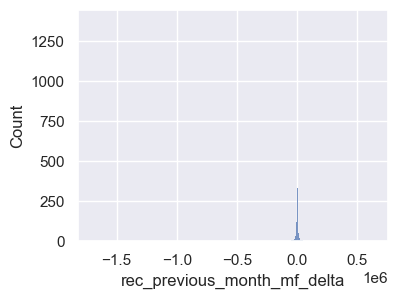

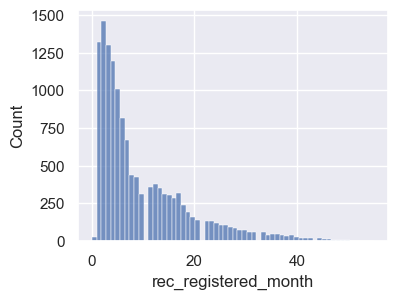

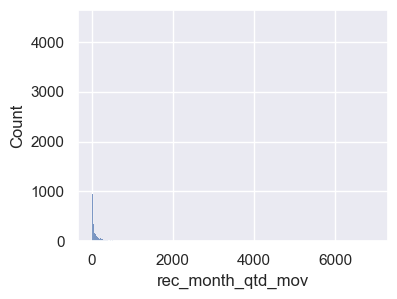

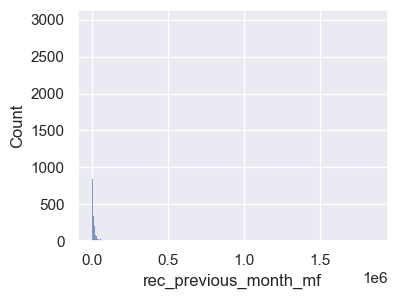

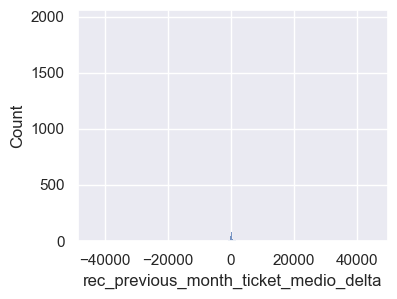

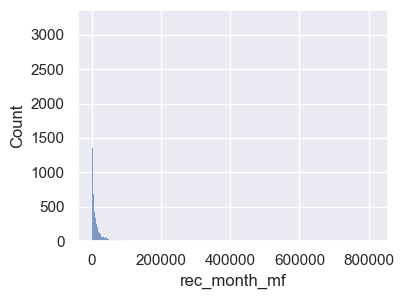

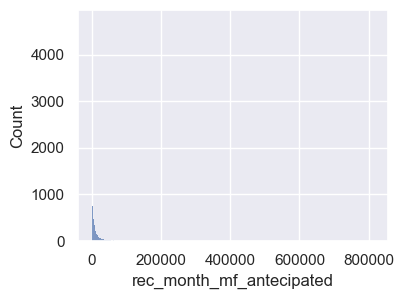

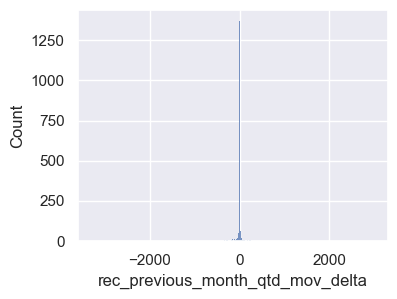

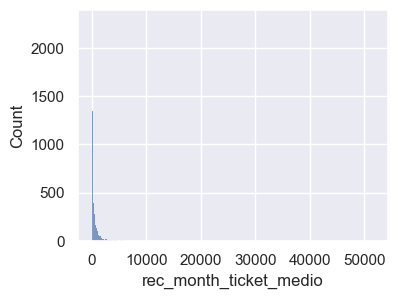

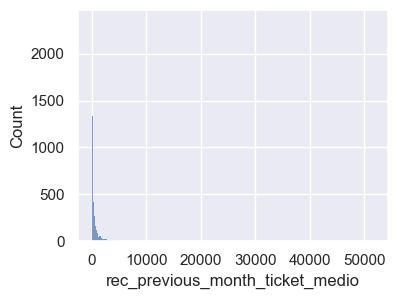

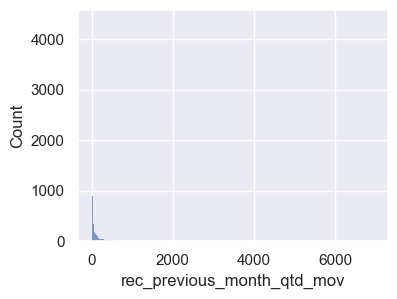

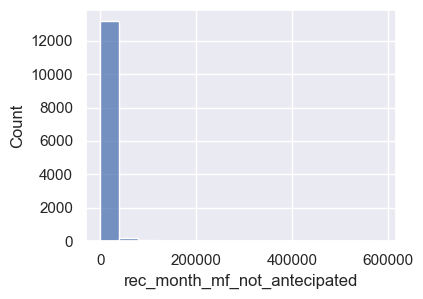

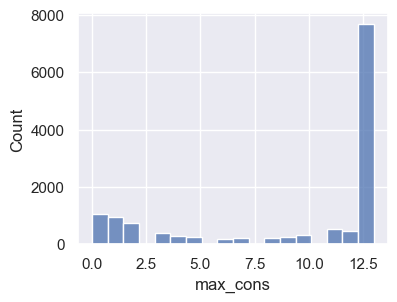

In [6]:
for c in numeric_variables:
    sns.set(rc={'figure.figsize':(4,3)})
    sns.histplot(x= (df_recorr[c]))
    plt.show()

Transforming with "Box-Coxing" variables to reduce skewness

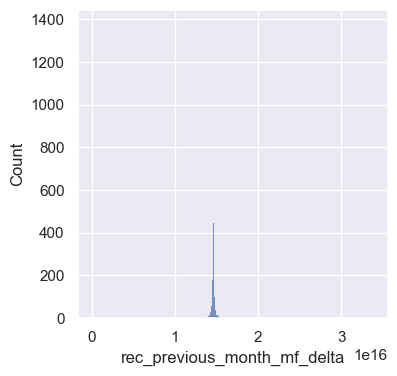

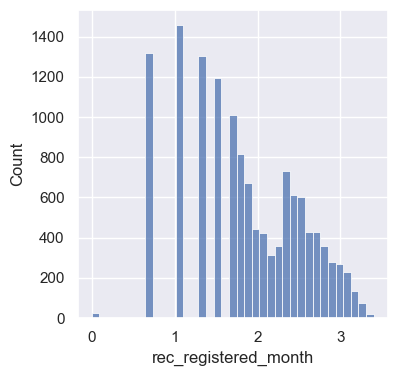

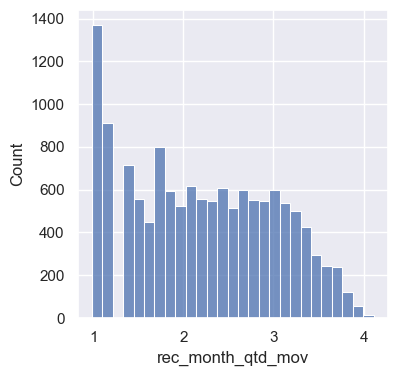

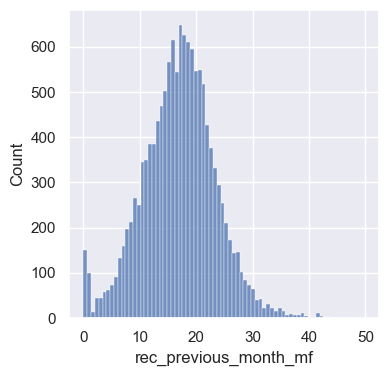

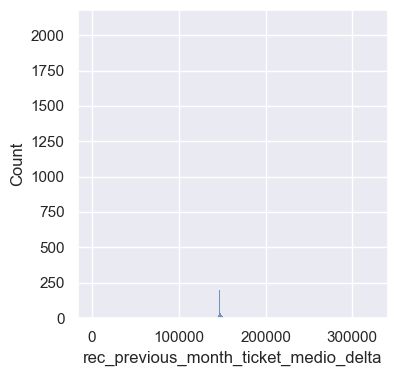

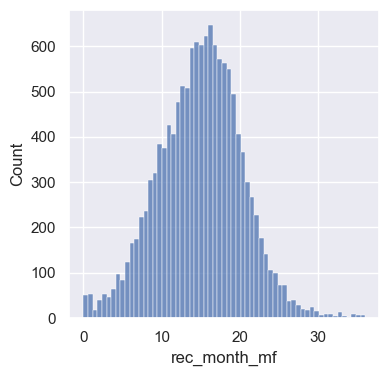

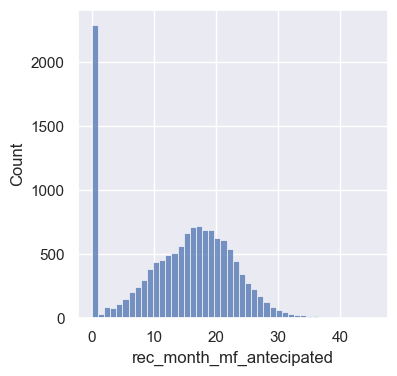

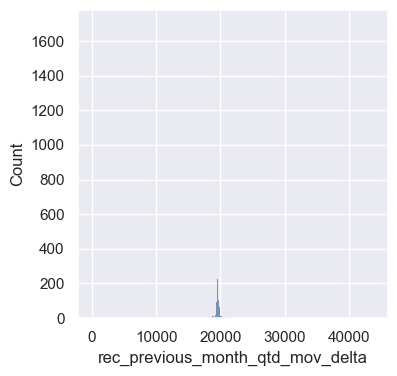

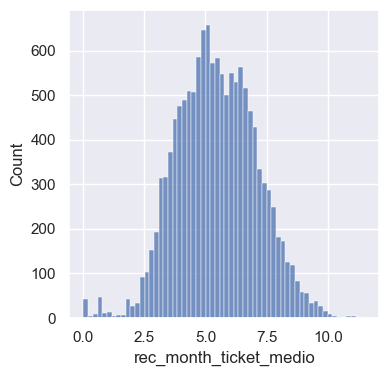

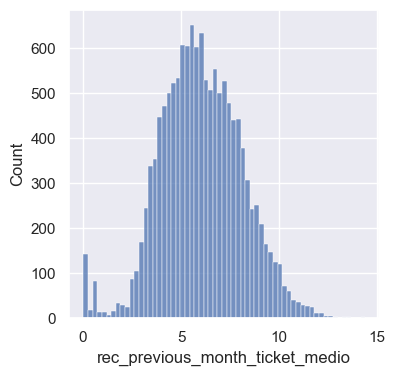

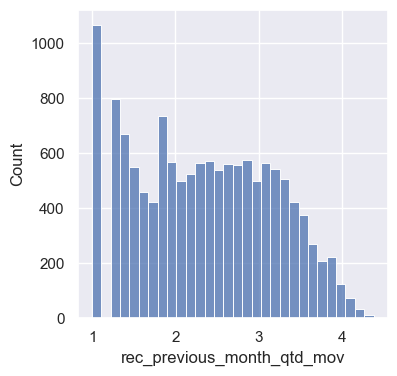

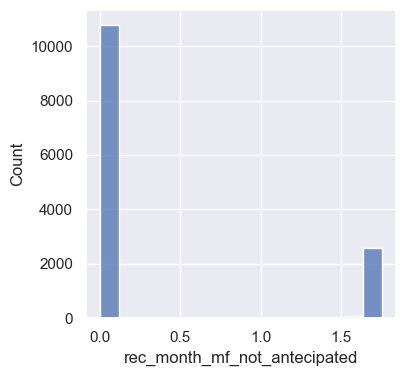

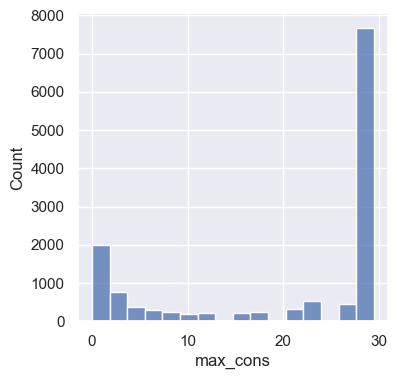

In [7]:
df_recorr_temp = df_recorr.copy()
for c in numeric_variables:
    sns.set(rc={'figure.figsize':(4,4)})
    min_val = df_recorr_temp[c].min()
    df_recorr_temp[c] = df_recorr_temp[c] + abs(min_val) + 1
    df_recorr_temp[c] = stats.boxcox(df_recorr_temp[c])[0]
    sns.histplot(x= df_recorr_temp[c])
    plt.show()

From the plots above it is possible to conclude that the most normaly distributed variables (excluding outliers) are: <br>
rec_month_mf, rec_previous_month_mf, rec_month_ticket_medio

Scaling Variables to be less susceptible to outliers

In [19]:
df_recorr_scaled = df_recorr[['rec_month_mf', 'rec_previous_month_mf', 
                              'rec_month_ticket_medio', 'rec_previous_month_ticket_medio', 
                              'rec_previous_month_qtd_mov_delta', 'rec_previous_month_mf_delta',
                              'rec_previous_month_ticket_medio_delta']].copy()

for c in df_recorr_scaled.columns:
    min_val = df_recorr_scaled[c].min()
    df_recorr_scaled[c] = df_recorr_scaled[c] + abs(min_val) + 1
    df_recorr_scaled[c] = stats.boxcox(df_recorr_scaled[c])[0]

Checking for high correlated features after scaling

<Axes: >

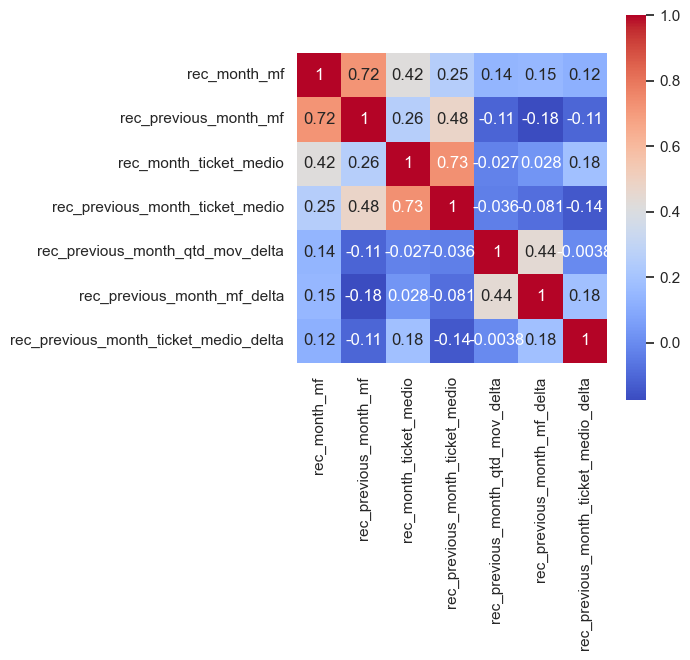

In [20]:
correlation_matrix = df_recorr_scaled.corr()
plt.figure(figsize=(5,5))
display(sns.heatmap(correlation_matrix, annot=True,cmap= 'coolwarm', square=True))

In [21]:
df_recorr_scaled = df_recorr_scaled[['rec_month_mf', 'rec_month_ticket_medio', 'rec_previous_month_qtd_mov_delta', 'rec_previous_month_mf_delta', 'rec_previous_month_ticket_medio_delta']]

features_recorr = df_recorr_scaled.columns.to_list()
feat_pairs = [(a, b) for idx, a in enumerate(features_recorr) for b in features_recorr[idx + 1:]]

The choosen models for this approach was a density-based models (DBSCAN), which allows us to have an idea about the number os clusters (without seting this value)
<br> and other two models that the n_cluster has to be choose (K-means and Mini Batch K-Means).
<br> All the models were tested with multiiple parameter values using Grid Search and then scored in order to know which is better. The scoring method was the silhouette score (or coefficient)

In [22]:
n_jobs = 7
model_dict = {
    'Birch':{
        'model': Birch(),
        'parameters':{
            'n_clusters': [4, 5, 6, 8],
            'threshold': [0.25, 0.5, 0.75, 1, 1.5]
        }
    },
    'GaussianMixture':{
        'model': GaussianMixture(),
        'parameters':{
            'n_components':[4, 5, 6, 8],
            'covariance_type': ['full', 'tied', 'diag', 'spherical']
        }
    },
    'DBSCAN':{
        'model': DBSCAN(),
        'parameters':{
            'min_samples':[5, 10, 20, 30, 50, 60],
            'eps': [0.25, 0.5, 1, 2.5, 5, 10, 15],
            'n_jobs':[n_jobs]
        }
    },
    'Kmeans':{
        'model': KMeans(),
        'parameters':{
            'n_clusters': [4, 5, 6, 8],
            'n_init': ['auto', 10, 20, 30]
        }
    },
    'MiniBatchKMeans':{
        'model': MiniBatchKMeans(),
        'parameters':{
            'n_clusters':[4, 5, 6, 8],
            'n_init': ['auto', 10, 20, 30]
        }
    }
}

model_rank = []

def cv_silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    num_labels = (len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0))
    num_samples = len(X.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return metrics.silhouette_score(X, cluster_labels) 
    
cv=[(slice(None), slice(None))] #cross validation it is not necessary

for name, conf, in model_dict.items():
    gsCV = GridSearchCV(conf['model'], conf['parameters'], cv=cv, return_train_score=False, scoring=cv_silhouette_scorer, n_jobs=7)
    gsCV.fit(df_recorr_scaled)
    model_rank.append({
        'model':name,
        'best_score':gsCV.best_score_,
        'best_parameters':gsCV.best_params_
    })

df_rank = pd.DataFrame(model_rank, columns=['model', 'best_score', 'best_parameters'])
df_rank.sort_values(by='best_score', ascending=False, inplace=True)

C:\Users\digom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [-0.64226264 -1.                 nan         nan         nan         nan
 -0.64187977 -0.64245409         nan         nan         nan         nan
 -0.64136931 -0.64136931         nan         nan         nan         nan
 -0.6405399  -0.6405399  -1.                 nan         nan         nan
 -0.64014637 -1.         -1.         -1.                 nan         nan
 -0.64000825 -1.         -1.         -1.         -1.                 nan
 -0.64000825 -1.         -1.         -1.         -1.                 nan]
  warnings.warn(


In [23]:
display(df_rank)

model  best_score                                 best_parameters
0            Birch    0.918937            {'n_clusters': 4, 'threshold': 0.25}
3           Kmeans    0.916098             {'n_clusters': 4, 'n_init': 'auto'}
1  GaussianMixture    0.901673  {'covariance_type': 'tied', 'n_components': 5}
4  MiniBatchKMeans    0.693220                 {'n_clusters': 4, 'n_init': 20}
2           DBSCAN   -0.640008      {'eps': 10, 'min_samples': 5, 'n_jobs': 7}

Due to the initialization randomness of these approachs, the Silhouette score can be different in distinct executions than the values above

In [24]:
def run_plot_model(df, estimator, feat_pairs):
    labels = estimator.fit_predict(df)

    print("Estimated number of clusters: %d" % (len(set(labels)) - (1 if -1 in labels else 0)))
    print("Estimated number of noise points: %d" % (list(labels).count(-1)))

    print(f"Silhouette Coefficient: {metrics.silhouette_score(df, labels):.3f}")

    df['cluster'] = labels

    for feat1, feat2 in feat_pairs:
        sns.set(rc={'figure.figsize':(4,4)})
        sns.scatterplot(x=df[feat1], y=df[feat2], hue=df.cluster, palette= sns.color_palette(n_colors= len(set(labels))))
        plt.show()

Once tested and scored we have to look on how each model behaves with the data by plotting them

Birch

Estimated number of clusters: 4
Estimated number of noise points: 0
Silhouette Coefficient: 0.919


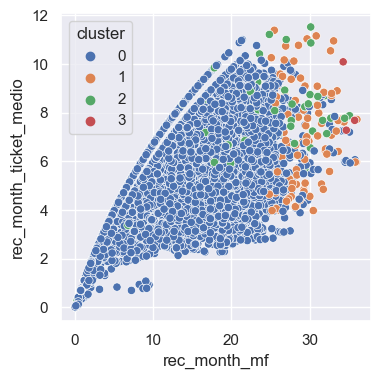

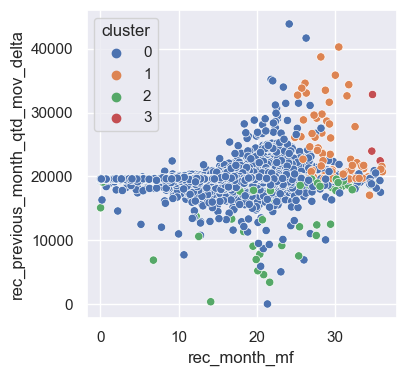

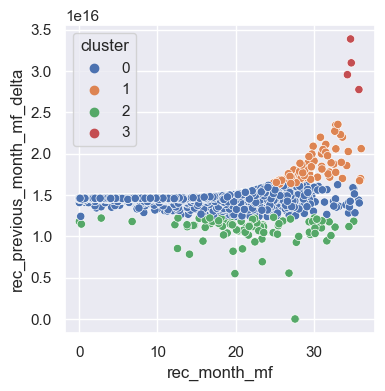

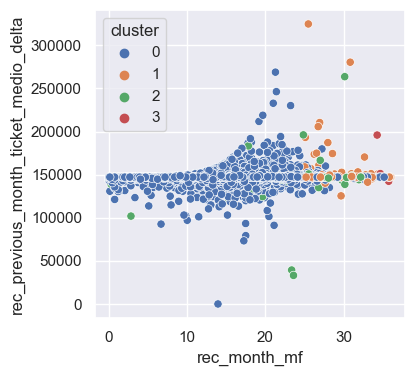

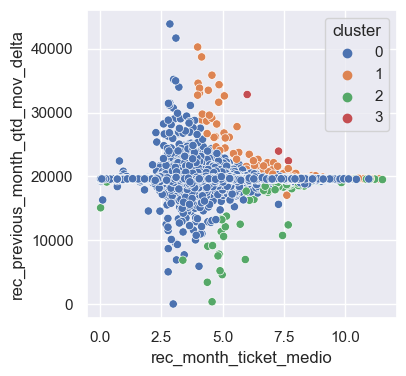

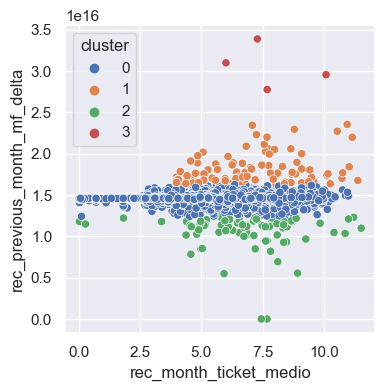

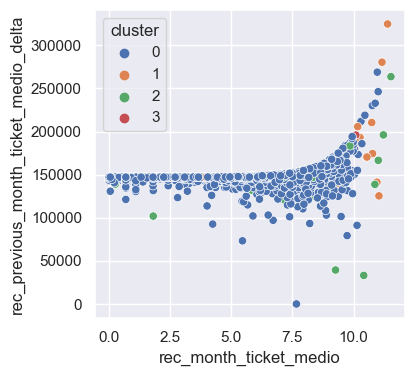

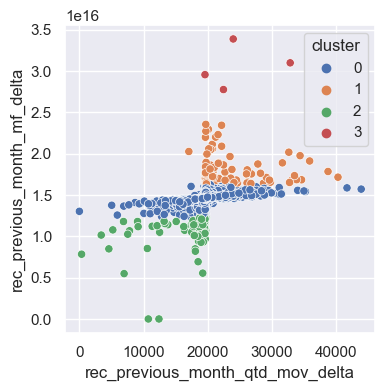

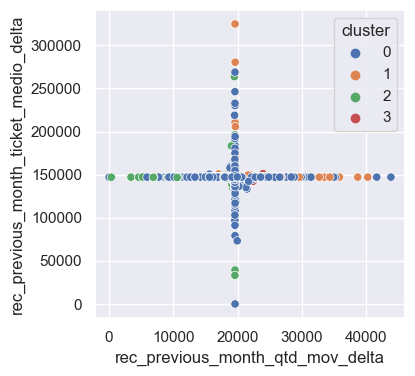

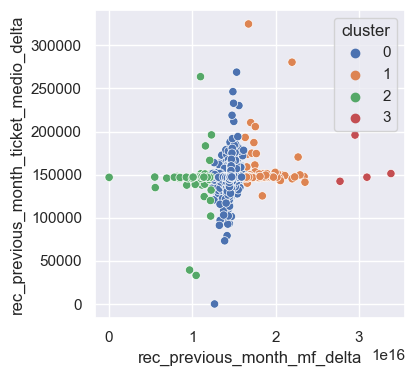

In [25]:
run_plot_model(df_recorr_scaled, 
               Birch(n_clusters= df_rank.loc[df_rank['model'] == 'Birch', 'best_parameters'].iloc[0]['n_clusters'],
                    threshold=df_rank.loc[df_rank['model'] == 'Birch', 'best_parameters'].iloc[0]['threshold']), 
               feat_pairs= feat_pairs)

Gaussian Mixture

Estimated number of clusters: 5
Estimated number of noise points: 0
Silhouette Coefficient: 0.811


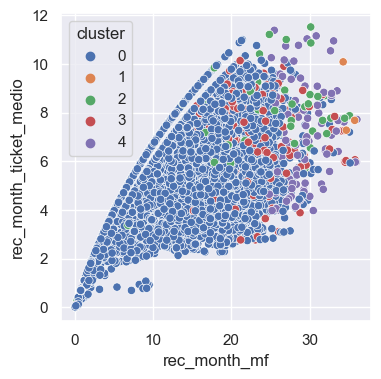

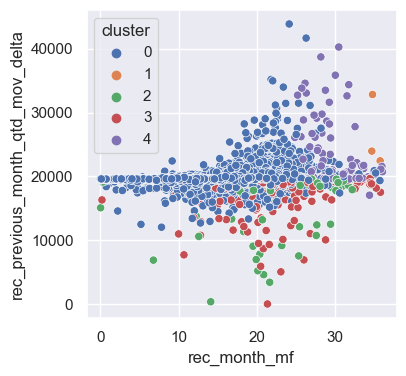

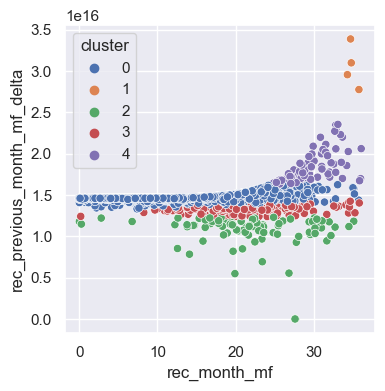

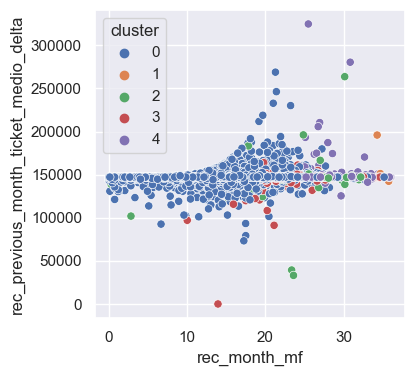

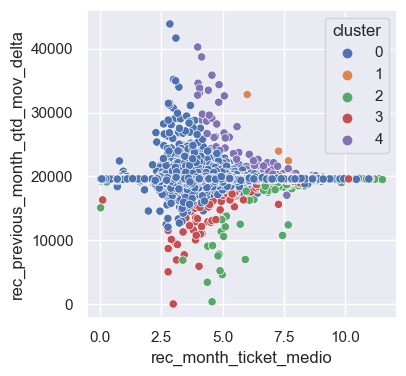

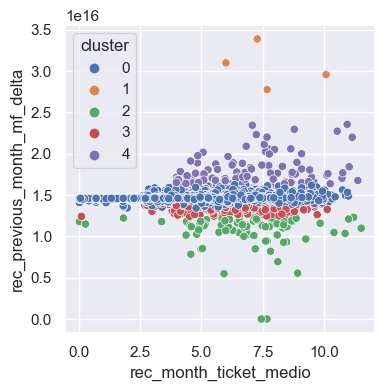

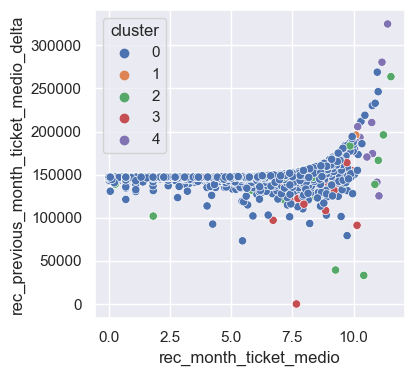

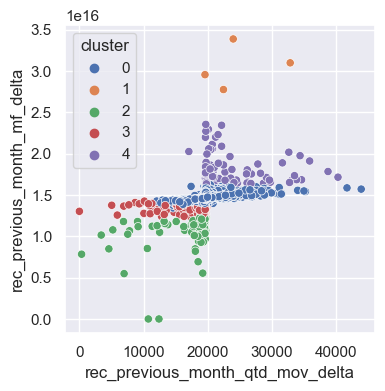

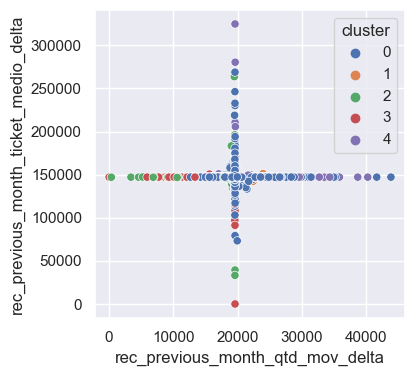

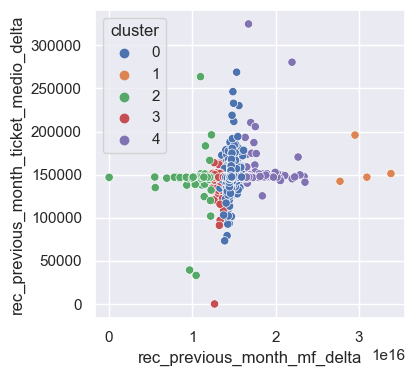

In [26]:
run_plot_model(df_recorr_scaled, 
               GaussianMixture(n_components= df_rank.loc[df_rank['model'] == 'GaussianMixture', 'best_parameters'].iloc[0]['n_components'],
                               covariance_type=df_rank.loc[df_rank['model'] == 'GaussianMixture', 'best_parameters'].iloc[0]['covariance_type']), 
               feat_pairs= feat_pairs)

Mini Batch K-means

Estimated number of clusters: 4
Estimated number of noise points: 0
Silhouette Coefficient: 0.305


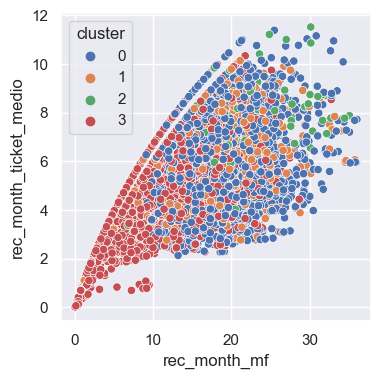

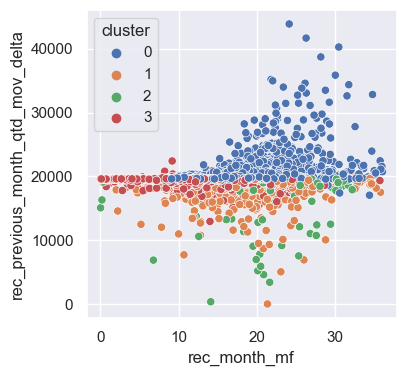

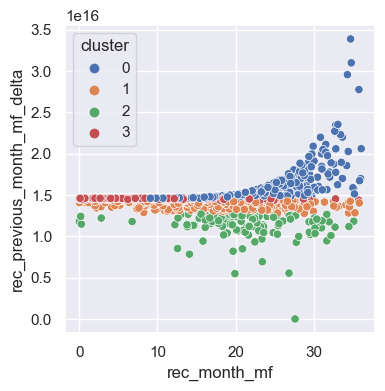

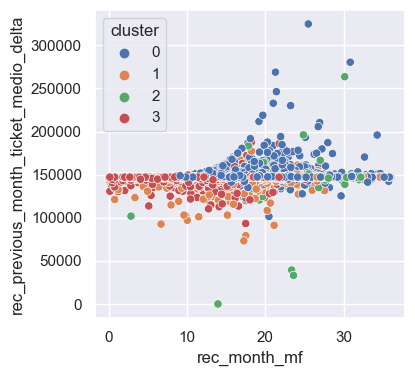

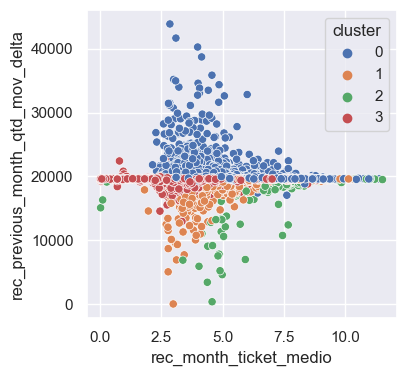

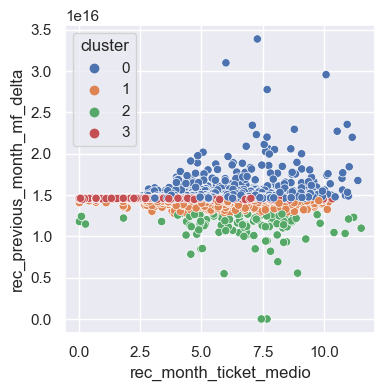

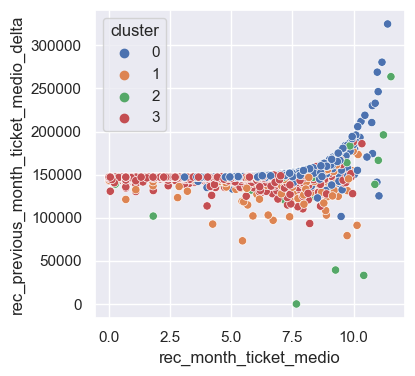

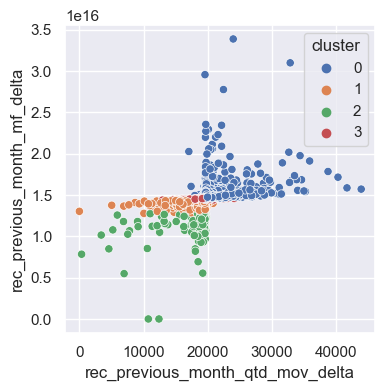

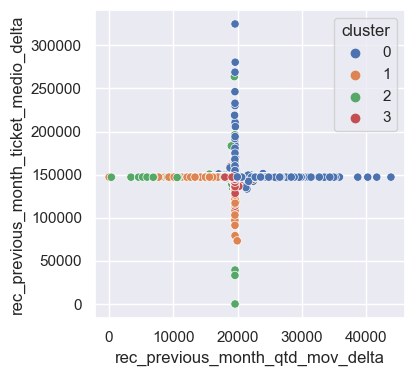

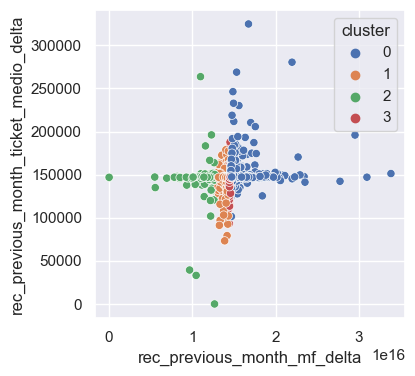

In [27]:
run_plot_model(df_recorr_scaled, 
               MiniBatchKMeans(n_clusters= df_rank.loc[df_rank['model'] == 'MiniBatchKMeans', 'best_parameters'].iloc[0]['n_clusters'],
                               n_init=df_rank.loc[df_rank['model'] == 'MiniBatchKMeans', 'best_parameters'].iloc[0]['n_init']), 
               feat_pairs= feat_pairs)

K-means

Estimated number of clusters: 4
Estimated number of noise points: 0
Silhouette Coefficient: 0.760


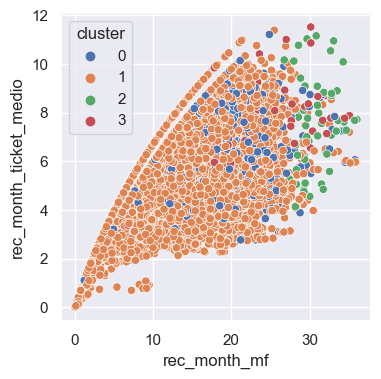

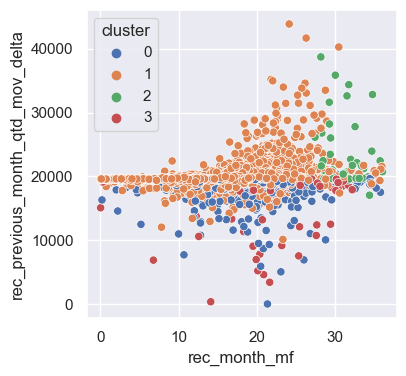

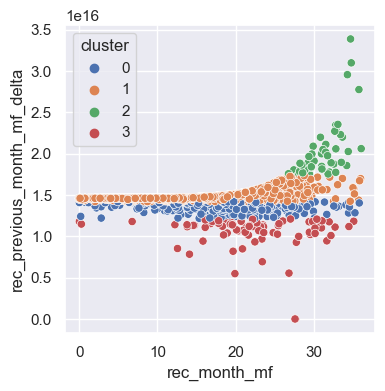

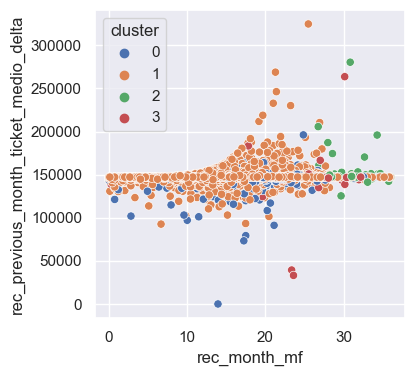

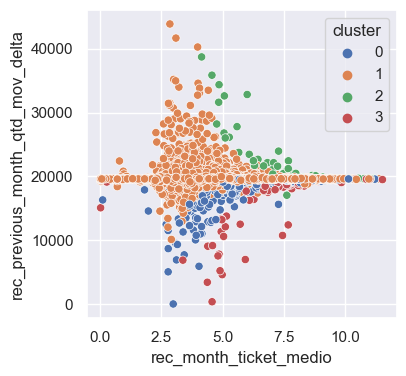

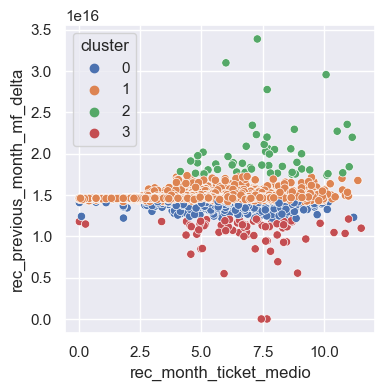

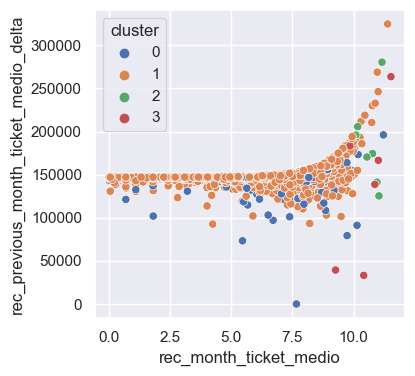

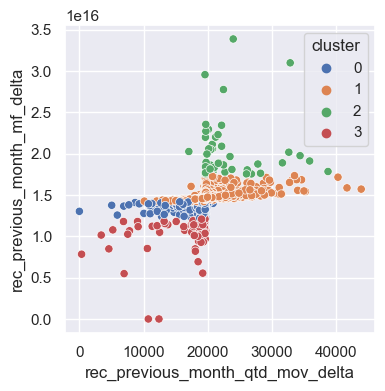

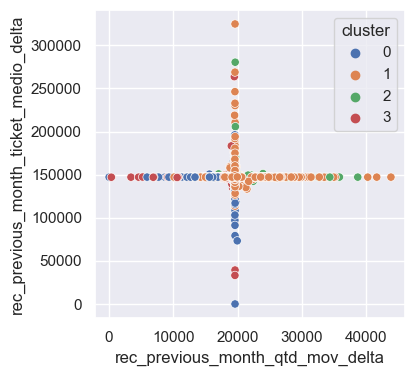

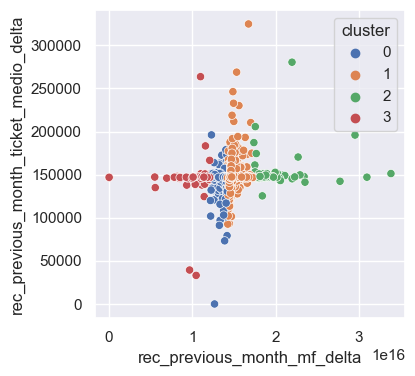

In [28]:
run_plot_model(df_recorr_scaled, 
               KMeans(n_clusters= df_rank.loc[df_rank['model'] == 'Kmeans', 'best_parameters'].iloc[0]['n_clusters'],
                      n_init=df_rank.loc[df_rank['model'] == 'Kmeans', 'best_parameters'].iloc[0]['n_init']), 
               feat_pairs= feat_pairs)

DBSCAN

Estimated number of clusters: 2
Estimated number of noise points: 13437
Silhouette Coefficient: -0.640


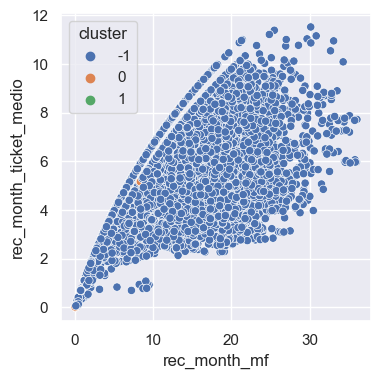

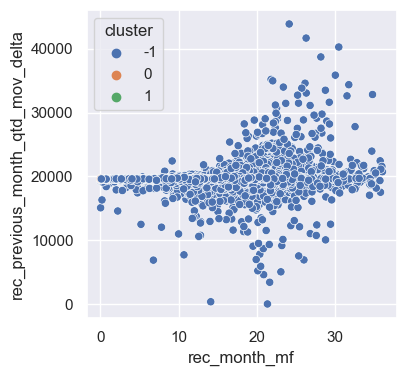

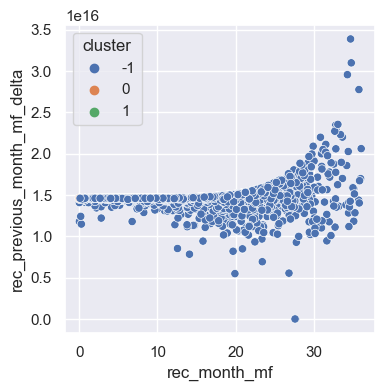

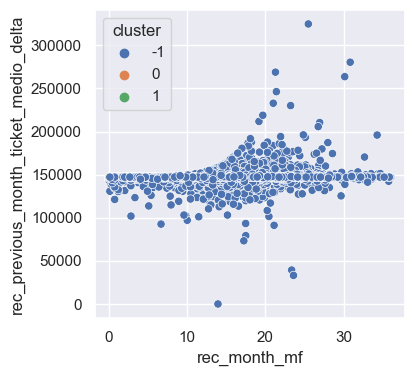

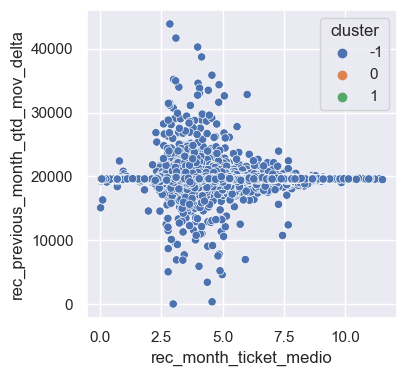

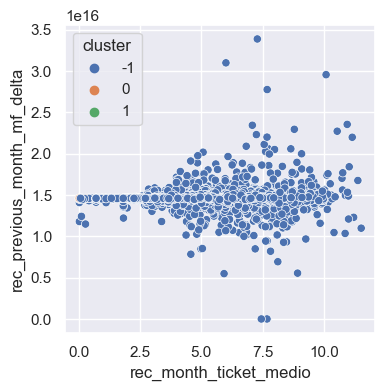

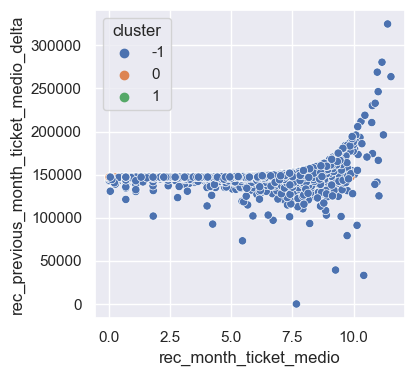

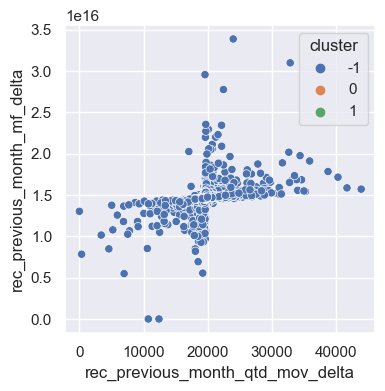

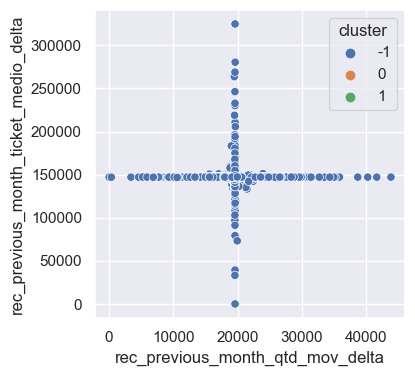

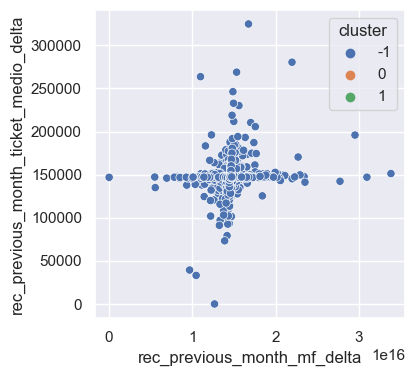

In [29]:
run_plot_model(df_recorr_scaled, 
               DBSCAN(eps= df_rank.loc[df_rank['model'] == 'DBSCAN', 'best_parameters'].iloc[0]['eps'],
                      min_samples= df_rank.loc[df_rank['model'] == 'DBSCAN', 'best_parameters'].iloc[0]['min_samples'], n_jobs=n_jobs), 
               feat_pairs= feat_pairs)